In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/casey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/casey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/casey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Loading the data
url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")

In [4]:
# Overview
print("\nData overview:")
print(f"Number of articles: {len(data)}")
print(data.info())
print("\nSample data:")
print(data.head())


Data overview:
Number of articles: 38686
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38686 entries, 0 to 38685
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_id    38686 non-null  object
 1   title     38686 non-null  object
 2   abstract  38686 non-null  object
 3   subject   38686 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB
None

Sample data:
              doc_id                                              title  \
0  S0960076016300644  Sterols and oxysterols in plasma from Smith-Le...   
1  S1471492219301369  The Uncertainty Surrounding the Burden of Post...   
2  S2405580815000801  Low-mass molecular dynamics simulation for con...   
3  S0142961216305853  Modulation of the molecular arrangement in art...   
4  S0003682X1500242X  Validation of the blocked force method for var...   

                                            abstract    subject  
0  Smith-Lemli-Opitz syndrome (SLOS) is a seve

In [5]:
# Checking for any missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
doc_id      0
title       0
abstract    0
subject     0
dtype: int64


In [6]:
print("\nSubject distribution:")
subject_counts = data['subject'].value_counts()
print(subject_counts)


Subject distribution:
subject
phys_sci     13048
engi_tech     9211
healh_sci     7633
life_sci      5651
soc_sci       3143
Name: count, dtype: int64


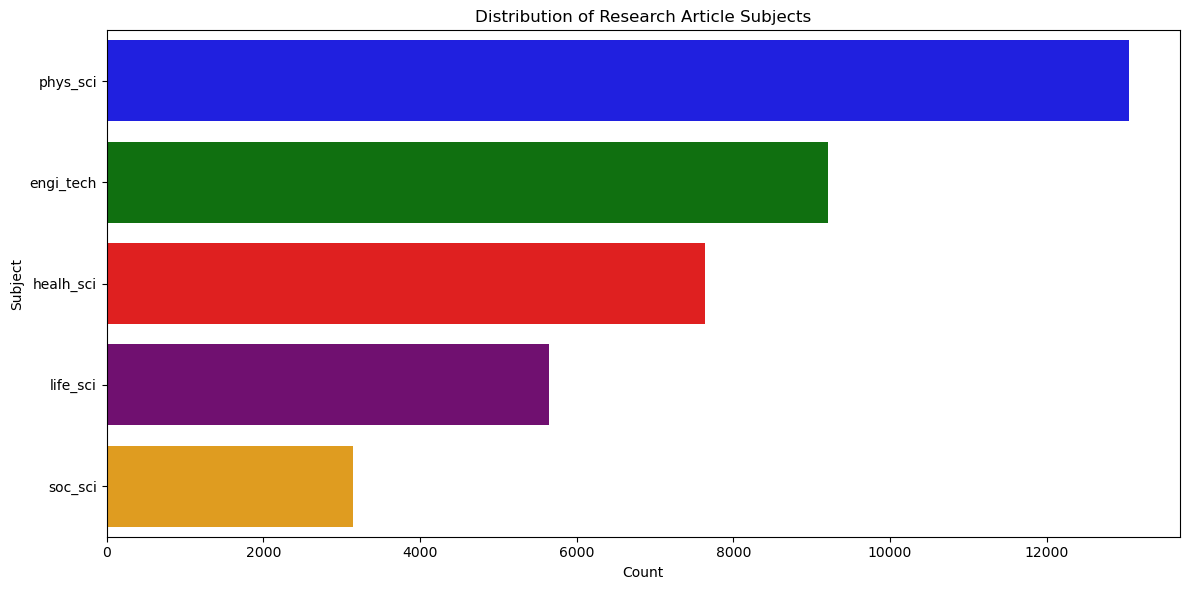

In [8]:
# Plotting the subject distribution with specific colors per subject
plt.figure(figsize=(12, 6))
colors = {'phys_sci': 'blue', 'engi_tech': 'green', 'healh_sci': 'red', 'life_sci': 'purple', 'soc_sci': 'orange'}
sns.barplot(x=subject_counts.values, y=subject_counts.index, palette=[colors[subj] for subj in subject_counts.index])
plt.title('Distribution of Research Article Subjects')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

In [13]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Converting to lowercase
    text = text.lower()
    
    # Removing the special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Removing the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [ ]:
data['processed_title'] = data['title'].apply(preprocess_text)
data['processed_abstract'] = data['abstract'].apply(preprocess_text)

# Combining the title and abstract
data['combined_text'] = data['processed_title'] + ' ' + data['processed_abstract']

In [15]:
# Splitting the data *80% and 20%)
X = data['combined_text']
y = data['subject']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Train set size: 30948
Test set size: 7738


In [16]:
# Multinomial Naive Bayes with TF-IDF
print("\nTraining Multinomial Naive Bayes with TF-IDF...")
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

print("\nNaive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_nb, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_nb, average='macro'):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred_nb, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))


Training Multinomial Naive Bayes with TF-IDF...

Naive Bayes Results:
Accuracy: 0.6732
Precision (macro): 0.6567
Recall (macro): 0.6656
F1 Score (macro): 0.6548

Classification Report:
              precision    recall  f1-score   support

   engi_tech       0.70      0.80      0.75      1842
   healh_sci       0.73      0.76      0.74      1527
    life_sci       0.65      0.45      0.53      1130
    phys_sci       0.67      0.63      0.65      2610
     soc_sci       0.54      0.70      0.61       629

    accuracy                           0.67      7738
   macro avg       0.66      0.67      0.65      7738
weighted avg       0.67      0.67      0.67      7738



In [17]:
# Logistic Regression with TF-IDF
print("\nTraining Logistic Regression with TF-IDF...")
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, C=1.0))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_lr, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_lr, average='macro'):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred_lr, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



Training Logistic Regression with TF-IDF...

Logistic Regression Results:
Accuracy: 0.7138
Precision (macro): 0.7151
Recall (macro): 0.6932
F1 Score (macro): 0.7028

Classification Report:
              precision    recall  f1-score   support

   engi_tech       0.78      0.77      0.77      1842
   healh_sci       0.77      0.77      0.77      1527
    life_sci       0.63      0.55      0.59      1130
    phys_sci       0.67      0.73      0.70      2610
     soc_sci       0.73      0.65      0.69       629

    accuracy                           0.71      7738
   macro avg       0.72      0.69      0.70      7738
weighted avg       0.71      0.71      0.71      7738



In [18]:
# Random Forest with TF-IDF
print("\nTraining Random Forest with TF-IDF...")
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Training Random Forest with TF-IDF...

Random Forest Results:
Accuracy: 0.6738
Precision (macro): 0.6925
Recall (macro): 0.6297
F1 Score (macro): 0.6462

Classification Report:
              precision    recall  f1-score   support

   engi_tech       0.70      0.78      0.74      1842
   healh_sci       0.73      0.79      0.76      1527
    life_sci       0.68      0.36      0.47      1130
    phys_sci       0.62      0.71      0.66      2610
     soc_sci       0.74      0.51      0.61       629

    accuracy                           0.67      7738
   macro avg       0.69      0.63      0.65      7738
weighted avg       0.68      0.67      0.67      7738



In [19]:
# Model Comparison
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
accuracy_scores = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf)
]
precision_scores = [
    precision_score(y_test, y_pred_nb, average='macro'),
    precision_score(y_test, y_pred_lr, average='macro'),
    precision_score(y_test, y_pred_rf, average='macro')
]
recall_scores = [
    recall_score(y_test, y_pred_nb, average='macro'),
    recall_score(y_test, y_pred_lr, average='macro'),
    recall_score(y_test, y_pred_rf, average='macro')
]
f1_scores = [
    f1_score(y_test, y_pred_nb, average='macro'),
    f1_score(y_test, y_pred_lr, average='macro'),
    f1_score(y_test, y_pred_rf, average='macro')
]

In [20]:
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0          Naive Bayes  0.673171   0.656653  0.665573  0.654753
1  Logistic Regression  0.713750   0.715102  0.693170  0.702792
2        Random Forest  0.673818   0.692508  0.629736  0.646187


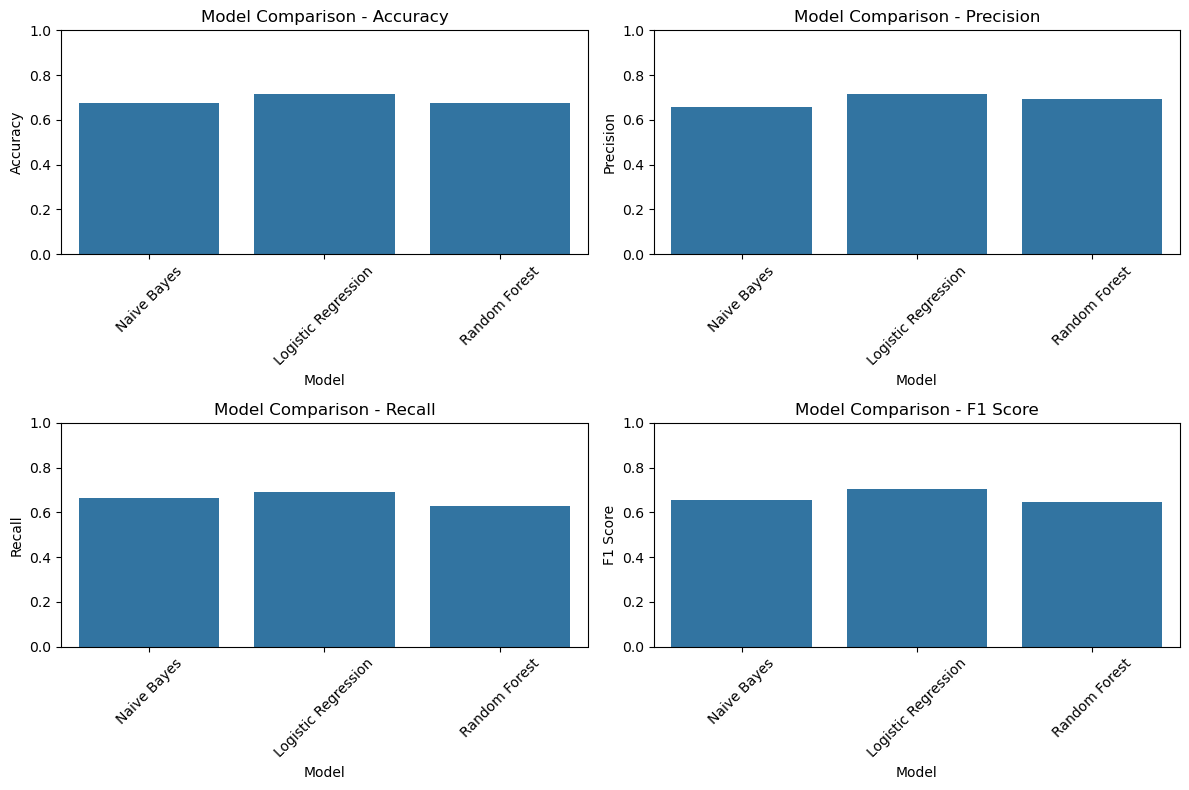

In [21]:
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(f'Model Comparison - {metric}')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Determining the best model based on precision
best_model_name = comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']
print(f"\nBest model based on precision: {best_model_name}")

# Get predictions and probabilities from the best model
if best_model_name == 'Naive Bayes':
    best_pipeline = nb_pipeline
    y_pred = y_pred_nb
elif best_model_name == 'Logistic Regression':
    best_pipeline = lr_pipeline
    y_pred = y_pred_lr
else:  # Random Forest
    best_pipeline = rf_pipeline
    y_pred = y_pred_rf



Best model based on precision: Logistic Regression



Confusion Matrix for the Best Model:


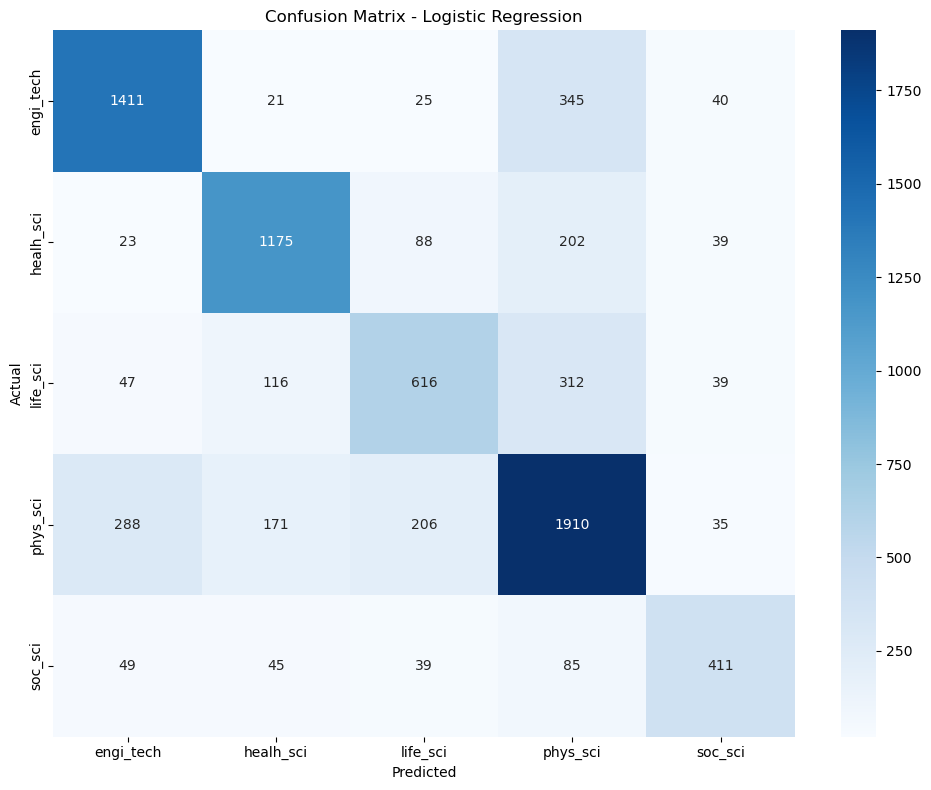

In [26]:
print("\nConfusion Matrix for the Best Model:")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

In [27]:
# Analyzing the misclassifications
misclassified_indices = np.where(y_test.values != y_pred)[0]
misclassified_data = data.iloc[y_test.index[misclassified_indices]].copy()
misclassified_data['predicted_subject'] = y_pred[misclassified_indices]

print("\nNumber of misclassified examples:", len(misclassified_data))


Number of misclassified examples: 2215


In [28]:
# Sample 5 misclassified examples
print("\nSample Misclassified Examples:")
sampled_misclassified = misclassified_data.sample(min(5, len(misclassified_data)))
for idx, row in sampled_misclassified.iterrows():
    print(f"\nArticle ID: {idx}")
    print(f"Title: {row['title']}")
    print(f"Abstract snippet: {row['abstract'][:200]}...")
    print(f"Actual subject: {row['subject']}")
    print(f"Predicted subject: {row['predicted_subject']}")
    
# Calculating the frequency of misclassifications by subject
misclass_by_subject = misclassified_data.groupby(['subject', 'predicted_subject']).size().reset_index()
misclass_by_subject.columns = ['Actual Subject', 'Predicted Subject', 'Count']
misclass_by_subject = misclass_by_subject.sort_values('Count', ascending=False)



Sample Misclassified Examples:

Article ID: 28198
Title: Tribology studies of the natural knee using an animal model in a new whole joint natural knee simulator
Abstract snippet: The successful development of early-stage cartilage and meniscus repair interventions in the knee requires biomechanical and biotribological understanding of the design of the therapeutic intervention...
Actual subject: phys_sci
Predicted subject: engi_tech

Article ID: 32796
Title: Nutritional and Metabolic Consequences of Feeding High-Fiber Diets to Swine: A Review
Abstract snippet: At present, substantial amounts of low-cost, fibrous co-products are incorporated into pig diets to reduce the cost of raising swine. However, diets that are rich in fiber are of low nutritive value b...
Actual subject: engi_tech
Predicted subject: life_sci

Article ID: 4998
Title: An exploratory study to test the impact on three "bolt-On" items to the EQ-5D
Abstract snippet: Background Generic preference-based measures were cri

In [30]:
misclass_by_subject = misclassified_data.groupby(['subject', 'predicted_subject']).size().reset_index()
misclass_by_subject.columns = ['Actual Subject', 'Predicted Subject', 'Count']
misclass_by_subject = misclass_by_subject.sort_values('Count', ascending=False)

print("\nTop Misclassification Patterns:")
print(misclass_by_subject.head(10))


Top Misclassification Patterns:
   Actual Subject Predicted Subject  Count
2       engi_tech          phys_sci    345
10       life_sci          phys_sci    312
12       phys_sci         engi_tech    288
14       phys_sci          life_sci    206
6       healh_sci          phys_sci    202
13       phys_sci         healh_sci    171
9        life_sci         healh_sci    116
5       healh_sci          life_sci     88
19        soc_sci          phys_sci     85
16        soc_sci         engi_tech     49
